In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import minmax_scale as mms
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [2]:
def load_data(path,name):
    csv_path = os.path.join(path, name)
    return pd.read_csv(csv_path)

In [3]:
path = "C:/Users/UX310UQ/Documents/Maestria_I/RedesNeurais/Redes neurais/RedesNeurais"
name = "winequality-red.csv"
data = load_data(path,name)
print("Loading wine dataset ...")
#data.info()

Loading wine dataset ...


# Pre-processing Data Set

In [4]:
print("Convert Categorical Output to One Hot Vector")
def categorical_output(Y_index): 
    #Y = data["category"]
    Y = Y_index.values.reshape(-1,1)
    enc = preprocessing.OneHotEncoder()
    enc.fit(Y)
    Y = enc.transform(Y).toarray() #Converting in hot vectors
    return Y

Convert Categorical Output to One Hot Vector


In [5]:
print("Preparing inputs droping Labels and droping indexs")
def preprocessing_input(X_index):
    #X = data
    #X = X_index.drop("Unnamed: 0", axis = 1)
    #X = X_index.drop("category", axis = 1)
    X = mms(X_index) #Scalling 
    return X
    #X.head()

Preparing inputs droping Labels and droping indexs


# NN L-Layer

In [6]:
def sigmoid(Z):
    S = 1 / (1 + np.exp(-Z))
    return S,Z

In [7]:
def derivade_sigmoid(z):
    gz,z = sigmoid(z) 
    return gz * (1-gz);

In [8]:
def initialize_parameters_deep(layer_dims):
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network, (including input layer)

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.normal(0, 1, (layer_dims[l], layer_dims[l-1]))
        parameters['b' + str(l)] = np.random.random((layer_dims[l], 1))
      
    return parameters

In [9]:
def initialize_velocity(parameters):
    L = len(parameters) // 2 # number of layers in the neural networks (not input layer including)
    v = {}
    
    for l in range(L):
        v["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l+1)])
        v["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l+1)])
        
    return v

# Forward Propagation in L - Layers

In [10]:
def linear_forward(A, W, b):
    Z = np.dot(W,A)+b
    cache = (A, W, b)
    return Z, cache

In [11]:
def linear_activation_forward(A_prev, W, b, activation):
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
        
    cache = (linear_cache, activation_cache) #linear_cahce: A_prev,Wi,bi - activation_cache: Zi
    return A, cache

In [12]:
def L_model_forward(X,Y,parameters,pred=False):
    caches = []
    A = X                                     #(input size, number of examples)
    L = len(parameters) // 2                  # number of layers in the neural network (not input layer including)
    
    # Implement [LINEAR -> SIGMOID]*(L-1). To L-1 Layers
    for l in range(1, L):
        A_prev = A 
        W=parameters['W' + str(l)]
        b=parameters['b' + str(l)]
        A, cache = linear_activation_forward(A_prev, W, b, "sigmoid")
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Last layer
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], "sigmoid")
    caches.append(cache)
    
    # Predicction
    if pred:
        # The max value is 1 , else 0
        AL_temp = AL.T
        Y_prediction = np.zeros_like(AL_temp)
        Y_prediction[np.arange(len(AL_temp)), AL_temp.argmax(1)] = 1
        Y_prediction = Y_prediction.T
        return Y_prediction
    return AL, caches

In [13]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = (- 1 / m) * np.sum(Y * np.log(AL) + (1 - Y) * (np.log(1 - AL)))
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    return cost

# Backward Propagation in L - Layers

In [14]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m) * np.dot(dZ,A_prev.T)
    db = (1/m) * np.sum(dZ,axis=1,keepdims=True)
    dA_prev = np.dot(W.T,dZ)
    return dA_prev, dW, db

In [15]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    
    if activation == "sigmoid":
        dZ = dA * derivade_sigmoid(activation_cache) # activation_cache = Z ; dA = np.dot(W.T,dZ) excep the first dA
    
    dA_prev, dW, db = linear_backward(dZ, linear_cache)    
    return dA_prev, dW, db

In [16]:
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) # the number of layers (not input layer including)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    # Initializing the backpropagation
    dAL =- (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) # derivative of cost with respect to AL
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, 
                                                                                                  current_cache, "sigmoid")
    
    for l in reversed(range(L-1)):
        # lth layer: (SIGMOID -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 2)], caches". Outputs: "grads["dA" + str(l + 1)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
        current_cache = caches[l]
        dA_prev, dW, db = linear_activation_backward(grads["dA" + str(l + 2)], current_cache, "sigmoid")
        grads["dA" + str(l + 1)] = dA_prev
        grads["dW" + str(l + 1)] = dW
        grads["db" + str(l + 1)] = db

    return grads

# Update Parameters

In [17]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2 # number of layers in the neural network (not input layer including)

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*grads["db" + str(l+1)]

    return parameters

# Update Parameters with Momentum

In [18]:
def update_parameters_with_momentum(parameters, grads, v, learning_rate, beta):
    L = len(parameters) // 2 # number of layers in the neural networks (not input layer including)
    
    # Momentum update for each parameter
    for l in range(L):
        v["dW" + str(l + 1)] = beta * v["dW" + str(l + 1)] + (1 - beta) * grads['dW' + str(l + 1)]
        v["db" + str(l + 1)] = beta * v["db" + str(l + 1)] + (1 - beta) * grads['db' + str(l + 1)]
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * v["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * v["db" + str(l + 1)]
        
    return parameters, v

# L - layer model

In [26]:
def L_layer_model(X, Y, X_test, Y_test, layers_dims, learning_rate, num_iterations, print_cost=False):
    np.random.seed(1)
    costs = []                         
    
    # Parameters initialization.
    parameters = initialize_parameters_deep(layers_dims)
    
    #Velocity initialization.
    v = initialize_velocity(parameters)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> SIGMOID]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X,Y,parameters,pred=False)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
    
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
 
        # Update parameters. #Esto tem que quedar comentado si vc vai usar com Momemtum
        #parameters = update_parameters(parameters, grads, learning_rate)
        
        # Update parameters with Momentum.
        parameters, v = update_parameters_with_momentum(parameters, grads, v, learning_rate, beta = 0.9)
                
        # Print the cost every 100 training example
        if print_cost and i % 500 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 500 == 0:
            costs.append(cost)
            
    # Train Predicction
    Y_prediction =  L_model_forward(X,Y,parameters,pred=True)
    print("------------------")
    print("Train Prediccion:")
    print(Y_prediction.shape)
    #print(Y_prediction)
    print("Train Accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction - Y)) * 100))
    print("Train F1 Score: ",f1_score(Y, Y_prediction, average='macro')*100)  
    
    # Test Predicction
    print("------------------")
    Y_prediction =  L_model_forward(X_test,Y_test,parameters,pred=True)
    print("Test Prediccion:")
    print(Y_prediction.shape)
    #print(Y_prediction)
    print("Test Accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction - Y_test)) * 100))
    print("Test F1 Score: ",f1_score(Y_test, Y_prediction, average='macro')*100)  



    if np.array_equal(Y,Y_prediction):
        print("Success Prediction")
    else:
        print("Un - success Prediction")
        
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
            
    
    return parameters

# Cross Validation

In [27]:
from sklearn.model_selection import StratifiedKFold
Y_index = data["category"]
X_index = data
X_index = X_index.drop("Unnamed: 0", axis = 1)
X_index = X_index.drop("category", axis = 1)
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(X_index, Y_index)
print(skf)

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)


Fold:  1
(1438, 11)
(1438, 3)
(161, 11)
(161, 3)
Cost after iteration 0: 1.961238
Cost after iteration 500: 0.856656
------------------
Train Prediccion:
(3, 1438)
Train Accuracy: 89.70792767732962 %
Train F1 Score:  84.56189151599443
------------------
Test Prediccion:
(3, 161)
Test Accuracy: 87.99171842650104 %
Test F1 Score:  81.98757763975155
Un - success Prediction


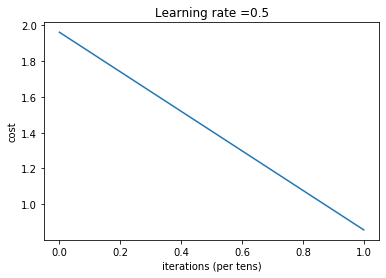

------------------
Fold:  2
(1438, 11)
(1438, 3)
(161, 11)
(161, 3)
Cost after iteration 0: 1.961630
Cost after iteration 500: 0.868734
------------------
Train Prediccion:
(3, 1438)
Train Accuracy: 89.47612424663885 %
Train F1 Score:  84.21418636995827
------------------
Test Prediccion:
(3, 161)
Test Accuracy: 90.06211180124224 %
Test F1 Score:  85.09316770186336
Un - success Prediction


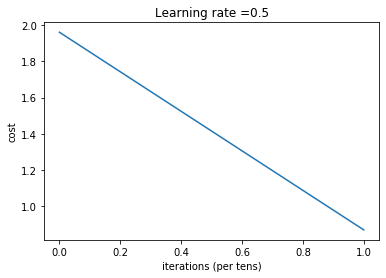

------------------
Fold:  3
(1438, 11)
(1438, 3)
(161, 11)
(161, 3)
Cost after iteration 0: 1.961381
Cost after iteration 500: 0.866822
------------------
Train Prediccion:
(3, 1438)
Train Accuracy: 89.47612424663885 %
Train F1 Score:  84.21418636995827
------------------
Test Prediccion:
(3, 161)
Test Accuracy: 86.33540372670808 %
Test F1 Score:  79.5031055900621
Un - success Prediction


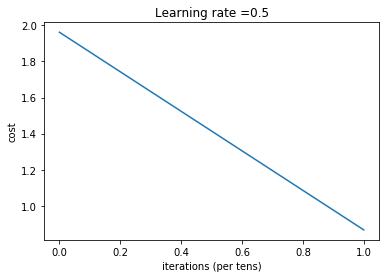

------------------
Fold:  4
(1439, 11)
(1439, 3)
(160, 11)
(160, 3)
Cost after iteration 0: 1.960965
Cost after iteration 500: 0.852501
------------------
Train Prediccion:
(3, 1439)
Train Accuracy: 89.62242297892055 %
Train F1 Score:  84.43363446838083
------------------
Test Prediccion:
(3, 160)
Test Accuracy: 87.5 %
Test F1 Score:  81.25
Un - success Prediction


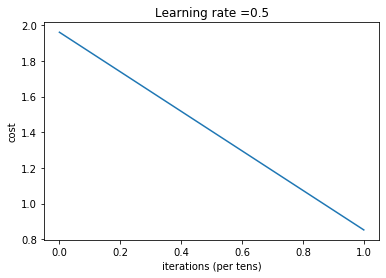

------------------
Fold:  5
(1439, 11)
(1439, 3)
(160, 11)
(160, 3)
Cost after iteration 0: 1.959067
Cost after iteration 500: 0.871466
------------------
Train Prediccion:
(3, 1439)
Train Accuracy: 89.25179522816771 %
Train F1 Score:  83.87769284225156
------------------
Test Prediccion:
(3, 160)
Test Accuracy: 87.91666666666667 %
Test F1 Score:  81.875
Un - success Prediction


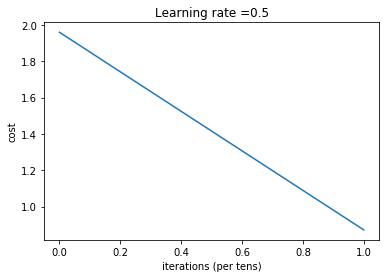

------------------
Fold:  6
(1439, 11)
(1439, 3)
(160, 11)
(160, 3)
Cost after iteration 0: 1.961410
Cost after iteration 500: 0.878622
------------------
Train Prediccion:
(3, 1439)
Train Accuracy: 89.34445216585591 %
Train F1 Score:  84.01667824878388
------------------
Test Prediccion:
(3, 160)
Test Accuracy: 88.33333333333333 %
Test F1 Score:  82.5
Un - success Prediction


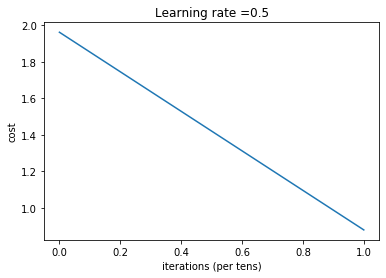

------------------
Fold:  7
(1439, 11)
(1439, 3)
(160, 11)
(160, 3)
Cost after iteration 0: 1.961720
Cost after iteration 500: 0.847815
------------------
Train Prediccion:
(3, 1439)
Train Accuracy: 89.29812369701182 %
Train F1 Score:  83.94718554551773
------------------
Test Prediccion:
(3, 160)
Test Accuracy: 81.66666666666667 %
Test F1 Score:  72.5
Un - success Prediction


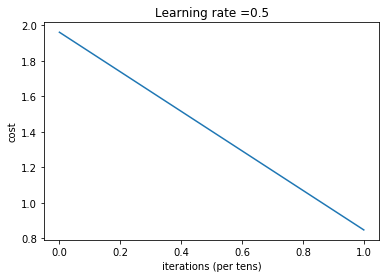

------------------
Fold:  8
(1440, 11)
(1440, 3)
(159, 11)
(159, 3)
Cost after iteration 0: 1.962032
Cost after iteration 500: 0.855434
------------------
Train Prediccion:
(3, 1440)
Train Accuracy: 89.30555555555556 %
Train F1 Score:  83.95833333333333
------------------
Test Prediccion:
(3, 159)
Test Accuracy: 81.9706498951782 %
Test F1 Score:  72.95597484276729
Un - success Prediction


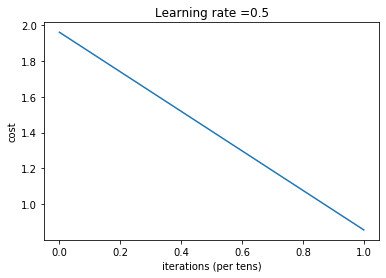

------------------
Fold:  9
(1440, 11)
(1440, 3)
(159, 11)
(159, 3)
Cost after iteration 0: 1.963464
Cost after iteration 500: 0.881885
------------------
Train Prediccion:
(3, 1440)
Train Accuracy: 89.25925925925927 %
Train F1 Score:  83.88888888888889
------------------
Test Prediccion:
(3, 159)
Test Accuracy: 89.51781970649895 %
Test F1 Score:  84.27672955974843
Un - success Prediction


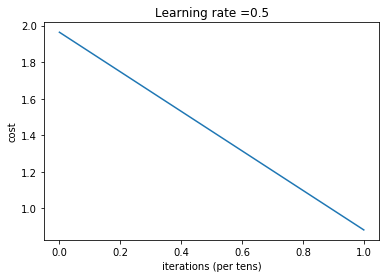

------------------
Fold:  10
(1441, 11)
(1441, 3)
(158, 11)
(158, 3)
Cost after iteration 0: 1.963045
Cost after iteration 500: 0.856754
------------------
Train Prediccion:
(3, 1441)
Train Accuracy: 89.17418459403191 %
Train F1 Score:  83.76127689104788
------------------
Test Prediccion:
(3, 158)
Test Accuracy: 89.45147679324894 %
Test F1 Score:  84.17721518987342
Un - success Prediction


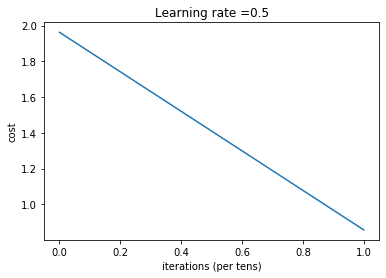

------------------


In [28]:
fold = 1
layers_dims = [11, 9, 7, 5 ,3] 
for train_index, test_index in skf.split(X_index, Y_index):
    print("Fold: ",fold)
    fold += 1
    X_train, X_test = X_index.iloc[train_index], X_index.iloc[test_index]
    Y_train, Y_test = Y_index[train_index], Y_index[test_index]
    X_train = preprocessing_input(X_train)
    X_test = preprocessing_input(X_test)
    Y_train = categorical_output(Y_train)
    Y_test = categorical_output(Y_test) #Fix
    print(X_train.shape)
    print(Y_train.shape)
    print(X_test.shape)
    print(Y_test.shape)
    
    parameters = L_layer_model(X_train.T, Y_train.T, X_test.T, Y_test.T, layers_dims, learning_rate = 0.5, num_iterations = 1000, print_cost = True)
    print("------------------")